In [16]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
ds = xr.open_dataset('../raster_outputs/r025/firespain_025_WGS84_v0.3.nc')

# Convertir el conjunto de datos a un DataFrame de Pandas
# Primero, si quieres trabajar con un DataFrame con las variables como columnas:
df = ds.to_dataframe()

In [4]:
df = df.reset_index()

In [5]:
#Metemos un indice para pares coordenadas latitude longitud específicas
lat_lon = df[['longitude','latitude']].drop_duplicates()
lat_lon = lat_lon.reset_index(drop = True).reset_index().rename(columns = {'index' : 'pixel'})
df = pd.merge(lat_lon,df,how = 'inner', on = ['longitude','latitude'])
#Eliminamos NA ya que pueden ser agua
df = df.dropna()

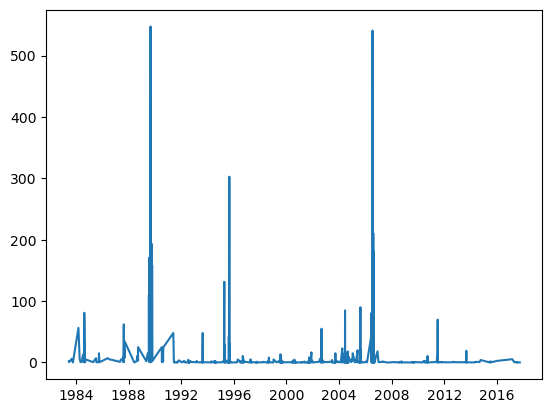

In [14]:
pixel = 35
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
plt.plot((df_pixel))
plt.show()

Se puede ver una regularidad estacional

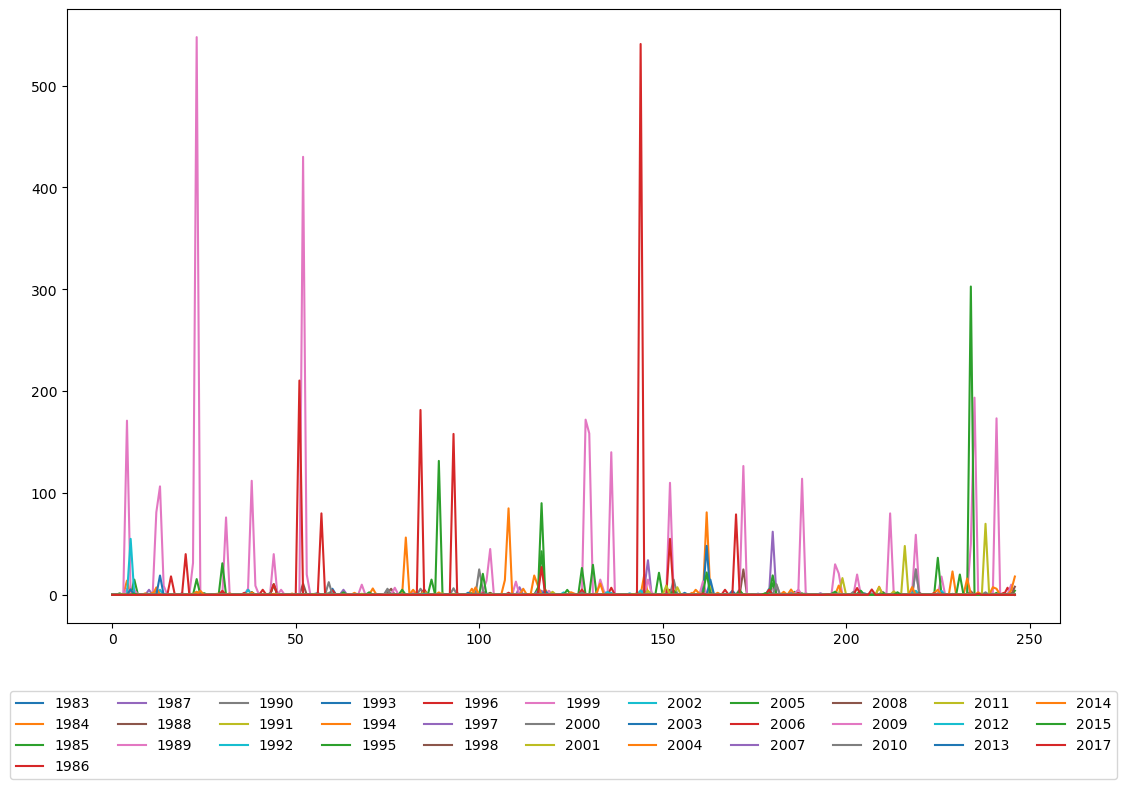

In [32]:
pixel = 35

df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['dia_mes'] = df_pixel['time'].dt.strftime('%d-%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='dia_mes', columns='año', values='ba', aggfunc='first')
df_pixel = df_pixel.reset_index(drop = True)
df_pixel = df_pixel.fillna(0)
plt.figure(figsize=(12, 8)) 
for year in df_pixel.columns:
    serie = df_pixel[year]
    plt.plot(serie,label = year)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=11) 
plt.tight_layout()
plt.show()



### Promedios

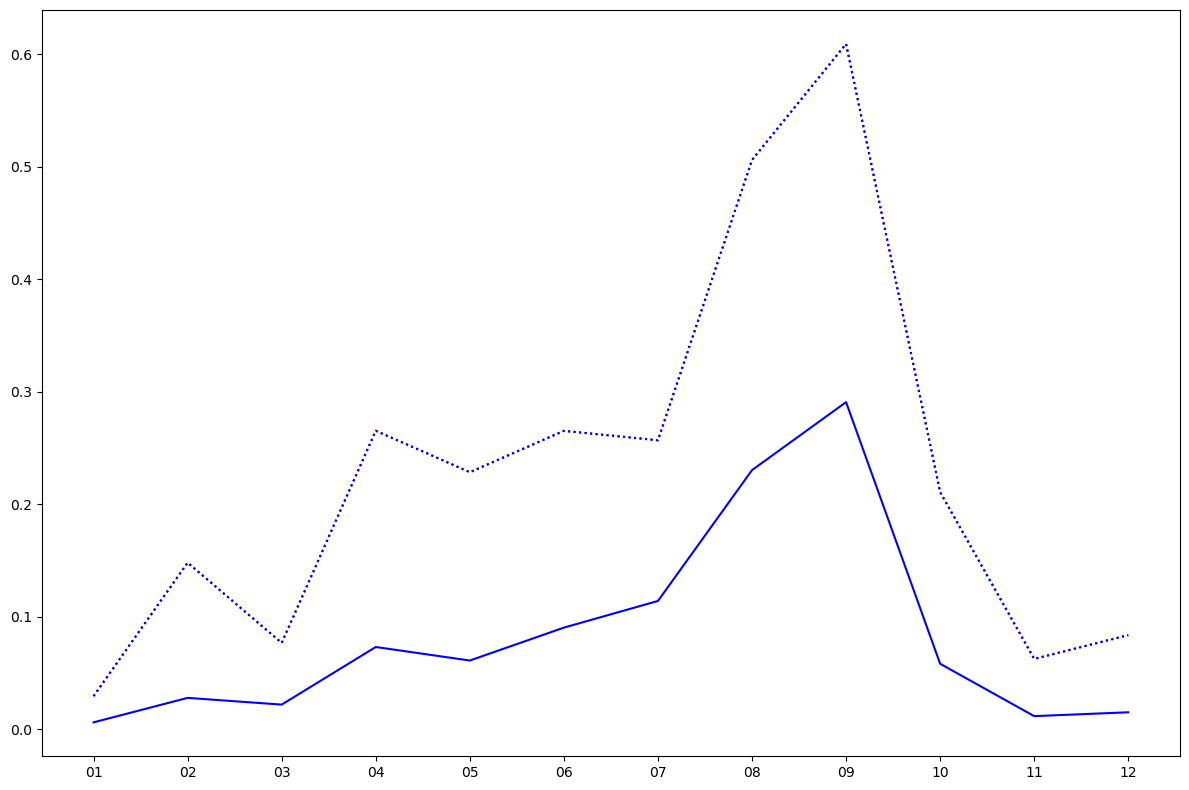

In [179]:
pixel = 35 
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum')
df_pixel = df_pixel.fillna(0)
df_pixel = df_pixel.div(df_pixel.sum(), axis=1)

serie = df_pixel.T.mean()
serie_std = df_pixel.T.std()
serie_max = df_pixel.T.max()
plt.figure(figsize=(12, 8)) 
plt.plot(serie, color='Blue')
plt.plot(serie + serie_std, linestyle='dotted', color='Blue')
plt.plot(serie + serie_std, linestyle='dotted', color='Blue')
plt.tight_layout()
plt.show()

##### Promediar primera y acumular después

1. Calcular la proporción de area quemada que cada mes aporta a la cantidad total de area quemada anual 
2. Calcular el promedio de dicha proporción para cada mes de todos los años
3. Calcular la suma acumulada
4. Ordenar los meses de mayor a menor 
5. Determinar qué meses son aquellos que llegan a un porcentaje de tierra quemada del 80% 0 90%

In [ ]:
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum') #pivotamos para situar los años en columnas y los meses en filas sumando la cantidad total de area quemada que hay para cada mes y año
df_pixel = df_pixel.fillna(0) #sustituir nan por ceros, meses donde ha habido incendio hay 0 ha de area quemada
df_pixel = df_pixel.div(df_pixel.sum(), axis=1) #Proporción de area quemada que cada mes aporta a la cantidad total de area quemada anual
fireSeason = df_pixel.T.mean() #Se hace la media de proporción de area quemada para cada mes de todos los años

fireSeason_cumsum = fireSeason.sort_values(ascending = False).cumsum() # suma acumulada
print(df_cumsum)
indices = fireSeason_cumsum[fireSeason_cumsum <= 0.9].index #determinamos qué meses ( = indices) son aquellos que llegan a un area quemada del 90%
print('La fire season será: ', sorted(indices))

mes
09    0.290661
08    0.520907
07    0.634888
06    0.725167
04    0.798233
05    0.859282
10    0.917466
02    0.945328
03    0.967209
12    0.982255
11    0.993894
01    1.000000
dtype: float32
La fire season será:  ['04', '05', '06', '07', '08', '09']


##### Acumular primero y promediar después

1. Calcular la proporción de area quemada que cada mes aporta a la cantidad total de area quemada anual 
2. Suma acumulada para cada año y reemplazamos los valores repetidos consecutivos en la acumulación por cero
3. Identificamos los meses de cada año donde la suma acumulada supera o iguala un umbral del 90%
4. Calcular la frecuencia de meses que aparecen en total 
5. Identificar como Fire season aquellos meses que en conjunto aparezcan más del 80% de las veces

In [56]:
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum') #pivotamos para situar los años en columnas y los meses en filas sumando la cantidad total de area quemada que hay para cada mes y año
df_pixel = df_pixel.fillna(0) #sustituir nan por ceros, meses donde ha habido incendio hay 0 ha de area quemada
df_pixel = df_pixel.div(df_pixel.sum(), axis=1) 

## calcular la suma acumulada para cada columna del DataFrame y, si un valor se repite en la acumulación, reemplazarlo por cero.
df_pixel_cumsum = df_pixel.cumsum()
df_pixel_cumsum_cleaned = df_pixel_cumsum.copy()

for col in df_pixel_cumsum.columns:
    # Iteramos sobre las filas para cada columna
    for i in range(1, len(df_pixel_cumsum)):
        if df_pixel_cumsum[col].iloc[i] == df_pixel_cumsum[col].iloc[i - 1]:
            df_pixel_cumsum_cleaned[col].iloc[i] = 0

## obtener los índices de las filas donde la suma acumulada alcanza o supera un umbral específico

threshold = 0.9

# Inicializamos un diccionario para guardar los índices por columna
indices_threshold = {}

# Para cada columna en el DataFrame de suma acumulada
for col in df_pixel_cumsum_cleaned.columns:
    # Encontramos los índices donde la suma acumulada alcanza o supera el umbral
    indices = df_pixel_cumsum_cleaned[col][df_pixel_cumsum_cleaned[col] >= threshold].index.tolist()
    
    # Guardamos los índices en el diccionario
    indices_threshold[col] = indices
indices_threshold

C:\Users\delatorrei\AppData\Local\Temp\ipykernel_10540\3758035730.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pixel_cumsum_cleaned[col].iloc[i] = 0


{1983: ['09', '10'],
 1984: ['08', '09'],
 1985: ['10'],
 1986: ['09'],
 1987: ['09'],
 1988: ['09'],
 1989: ['10'],
 1990: ['08'],
 1991: ['07', '08', '09', '10'],
 1992: ['09'],
 1993: ['08', '09', '11'],
 1994: ['08', '09', '10', '11'],
 1995: ['08', '09', '10', '11'],
 1996: ['09', '10'],
 1997: ['10'],
 1998: ['09', '12'],
 1999: ['09'],
 2000: ['09', '10'],
 2001: ['11', '12'],
 2002: ['09', '10'],
 2003: ['09', '11'],
 2004: ['09', '12'],
 2005: ['08', '09', '10', '12'],
 2006: ['08', '09', '12'],
 2007: ['04', '08', '10'],
 2008: ['09', '10', '11'],
 2009: ['09'],
 2010: ['09', '10'],
 2011: ['06', '07', '08', '10'],
 2012: ['09'],
 2013: ['09', '10'],
 2014: ['10'],
 2015: ['12'],
 2017: ['07', '08', '09']}

En la salida anterior vemos para cada año, los meses en donde se quema hasta el 90% de la tierra quemada de dicho año. Ahora calculamos la frecuenciatotal en que sale cada mes y estimamos la fire season como aquellos meses que más frecuentemente salen.

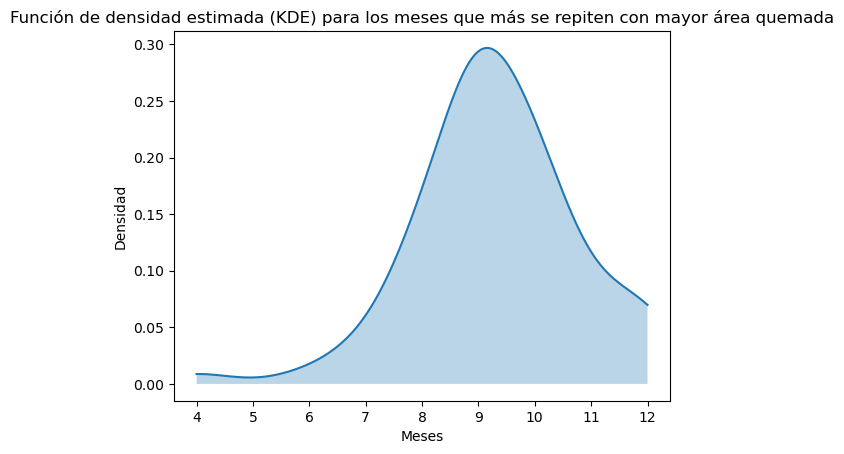

In [110]:
from scipy.stats import gaussian_kde
import numpy as np
all_indices = []

for indices in indices_threshold.values():
    all_indices.extend(indices)

all_indices_array = np.array(all_indices, dtype=np.float64)
kde = gaussian_kde(all_indices_array, bw_method='scott')  # 'scott' es el ancho de banda
kde.set_bandwidth(bw_method='silverman')  # Ajuste del ancho de banda, puedes experimentar con esto

# Generamos un rango de valores para evaluar la densidad
index_range = np.linspace(min(all_indices_array), max(all_indices_array), 1000)

# Evaluamos la densidad en esos puntos
density_values = kde(index_range)

# Graficamos la función de densidad
plt.plot(index_range, density_values, label="Densidad estimada")
plt.fill_between(index_range, density_values, alpha=0.3)
plt.title("Función de densidad estimada (KDE) para los meses que más se repiten con mayor área quemada")
plt.xlabel("Meses")
plt.ylabel("Densidad")
plt.show()

In [119]:
from collections import Counter
all_indices = []

for indices in indices_threshold.values():
    all_indices.extend(indices)
index_counts = Counter(all_indices) 

# Calculamos la proporción para cada índice
total_counts = len(all_indices)
index_proportions = {index: count / total_counts for index, count in index_counts.items()}

total_value = sum(index_proportions.values())

sorted_items = sorted(index_proportions.items(), key=lambda x: x[1], reverse=True)

# Inicializamos la suma acumulada y el diccionario de resultados
accumulated_sum = 0
selected_items = {}

# Iteramos y acumulamos los valores hasta llegar al 80%
for k, v in sorted_items:
    accumulated_sum += v
    selected_items[k] = v
    if accumulated_sum >= 0.80 * total_value:
        break
sorted_index_proportions = {k: v for k, v in sorted(selected_items.items(), reverse=False)}
sorted_index_proportions



{'08': 0.15714285714285714,
 '09': 0.35714285714285715,
 '10': 0.24285714285714285,
 '11': 0.08571428571428572}

#### Frecuencia incendios

Cantidad de incendios por mes

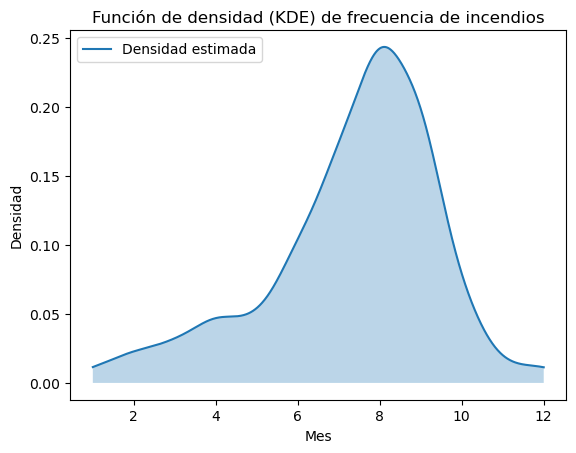

In [139]:
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel['ba'] = (df_pixel['ba'] > 0).astype(int)
df_pixel = df_pixel.reset_index()
df_pixel['mes'] = df_pixel['time'].dt.strftime('%m') 
df_pixel['año'] = df_pixel['time'].dt.year
df_pixel = df_pixel.pivot_table(index='mes', columns='año', values='ba', aggfunc='sum')
df_pixel = df_pixel.fillna(0)
frecs = df_pixel.fillna(0).T.reset_index(drop = True).sum().reset_index().rename(columns = {0 : 'cantidad'})

serie_repetida = frecs.apply(lambda row: [row['mes']] * int(row['cantidad']), axis=1).sum()

# Convertir la lista resultante en una Serie de pandas
serie = [int(i) for i in serie_repetida]

serie_array = np.array(serie, dtype=np.float64)

# Estimación de la densidad utilizando Kernel Density Estimation (KDE)
kde = gaussian_kde(serie_array, bw_method='scott')  # 'scott' es el ancho de banda
kde.set_bandwidth(bw_method='silverman')  # Ajuste del ancho de banda

# Generamos un rango de valores para evaluar la densidad
serie_range = np.linspace(min(serie_array), max(serie_array), 1000)

# Evaluamos la densidad en esos puntos
density_values = kde(serie_range)

# Graficamos la función de densidad
plt.plot(serie_range, density_values, label="Densidad estimada")
plt.fill_between(serie_range, density_values, alpha=0.3)
plt.title("Función de densidad (KDE) de frecuencia de incendios")
plt.xlabel("Mes")
plt.ylabel("Densidad")
plt.legend()
plt.show()

In [ ]:
fire_season = df_pixel.T.sum()/817 #hay 817 días donde ha ocurrido incencios
print(fire_season.sort_values(ascending = False))
indices = fire_season[fire_season >= 0.1].index #incluimos que al menos el 10% de las veces haya ocurrido en el mes especifico para incluirlo en la estación de incendios
indices

mes
08    0.259486
09    0.209302
07    0.166463
06    0.100367
10    0.062424
04    0.050184
05    0.042840
03    0.029376
02    0.023256
12    0.013464
01    0.011016
11    0.011016
dtype: float64


Index(['06', '07', '08', '09'], dtype='object', name='mes')

### Series temporales

In [141]:
pixel = 35
df_pixel = df[df['pixel'] == pixel]
df_pixel = df_pixel[['time','ba']].set_index('time')
df_pixel = df_pixel.reset_index()
#rellenamos toda la serie temporal ya que hay fechas que no aparecen
start_date = df_pixel['time'].min()
end_date = df_pixel['time'].max()
fechas = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D')).rename(columns = {0 : 'time'})
df_pixel = pd.merge(fechas,df_pixel, on = 'time', how = 'left').fillna(0) #aquellas fechas que no tienen area quemada se sustituyen por 0
df_pixel = df_pixel.set_index('time')

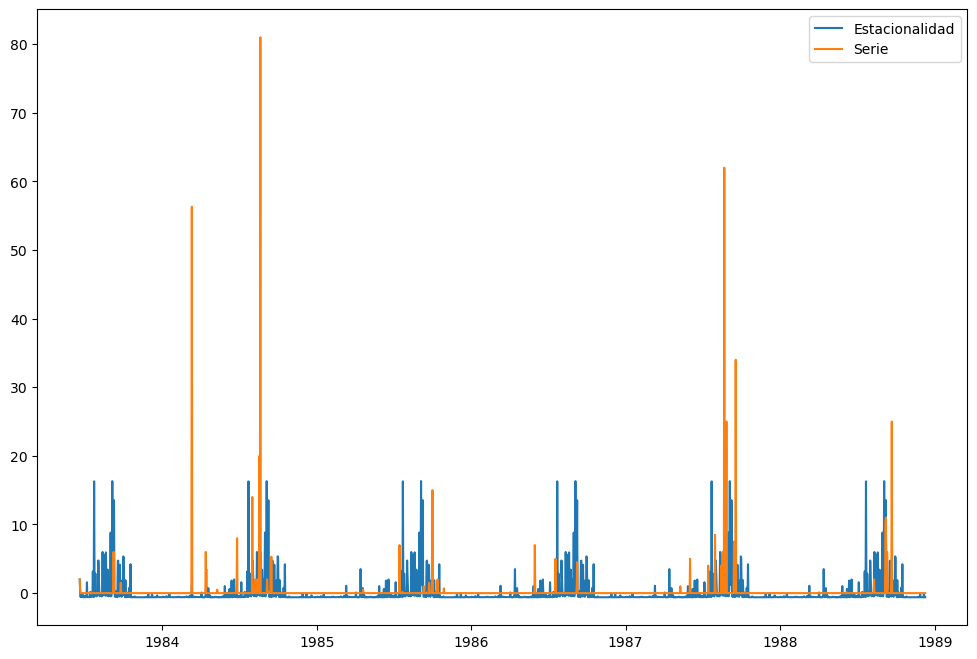

In [142]:
series = df_pixel['ba']
decomposition = seasonal_decompose(series, model='additive', period=365)  
seasonal = decomposition.seasonal
plt.figure(figsize=(12, 8)) 
plt.plot(seasonal[0:2000],label = 'Estacionalidad')
plt.plot(series[0:2000],label = 'Serie')
plt.legend()
plt.show()


In [157]:
threshold = seasonal.quantile(0.9)
fire_season_mask = (seasonal >= threshold).astype(int)

fsdf= fire_season_mask.reset_index()
fsdf['mes'] = fsdf['time'].dt.strftime('%m') 
fsdf['año'] = fsdf['time'].dt.year
fsdf = fsdf.pivot_table(index='mes', columns='año', values='seasonal', aggfunc='first')
fsdf = fsdf.fillna(0)
fire_season_estacionalidad = fsdf.T.sum()
print(fire_season_estacionalidad)
indices_no_cero = list(fire_season_estacionalidad[fire_season_estacionalidad != 0].index)
print(indices_no_cero)

mes
01     0.0
02     0.0
03     0.0
04     0.0
05     0.0
06     1.0
07     4.0
08     8.0
09    25.0
10     9.0
11     0.0
12     0.0
dtype: float64
['06', '07', '08', '09', '10']
